**Baidu - Autonomous Driving**

In [0]:
from PIL import Image, ImageDraw, ImageFont
from os import listdir
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization,Input
from keras.models import Model,load_model
from IPython.display import SVG
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras
from skimage.io import imread
from torchvision import models
from torchvision import transforms, utils

**1.1 Load Data from Kaggle**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload() #this will prompt you to update the json

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"lzx1126","key":"7e77be9cc545481af3f044f8c04efeb9"}'}

In [0]:
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c pku-autonomous-driving

 74% 5.00M/6.75M [00:00<00:00, 10.8MB/s]
100% 6.75M/6.75M [00:00<00:00, 13.7MB/s]
  0% 0.00/80.9k [00:00<?, ?B/s]
100% 80.9k/80.9k [00:00<00:00, 79.6MB/s]
  0% 0.00/1.11M [00:00<?, ?B/s]
100% 1.11M/1.11M [00:00<00:00, 36.5MB/s]
  0% 0.00/193 [00:00<?, ?B/s]
100% 193/193 [00:00<00:00, 166kB/s]
 63% 5.00M/7.90M [00:00<00:00, 13.4MB/s]
100% 7.90M/7.90M [00:00<00:00, 20.0MB/s]
 99% 1.60G/1.60G [00:29<00:00, 49.8MB/s]
100% 1.60G/1.60G [00:29<00:00, 59.0MB/s]
100% 502M/503M [00:11<00:00, 47.3MB/s]
100% 503M/503M [00:11<00:00, 47.2MB/s]
100% 2.83G/2.83G [00:42<00:00, 73.8MB/s]
100% 2.83G/2.83G [00:42<00:00, 71.0MB/s]
 52% 9.00M/17.2M [00:00<00:00, 17.9MB/s]
100% 17.2M/17.2M [00:00<00:00, 34.9MB/s]


In [8]:
!unzip -q "/content/train.csv.zip" -d "/content/sample_data/train"
!unzip -q "/content/train_images.zip" -d "/content/sample_data/train_images"
!unzip -q "/content/train_masks.zip" -d "/content/sample_data/train_masks"
!unzip -q "/content/test_images.zip" -d "/content/sample_data/test_images"
!unzip -q "/content/test_masks.zip" -d "/content/sample_data/test_masks"
!unzip -q "/content/car_models.zip" -d "/content/sample_data/car_models"
!unzip -q "/content/car_models_json.zip" -d "/content/sample_data/car_models_json"
!unzip -q "/content/camera.zip" -d "/content/sample_data/camera"

replace /content/sample_data/train/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


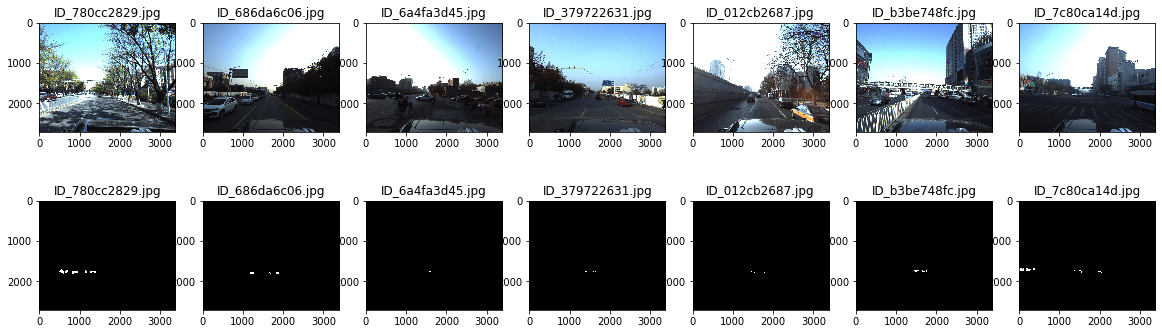

In [22]:
train_image_path = "/content/sample_data/train_images/"
train_mask_path = "/content/sample_data/train_masks/"
 
image_array = []
 
for root, dirs, files in os.walk(train_image_path): 
   image_array = files
 
col_size = 7
row_size = 2
 
rand_id_array = random.sample(range(0, len(image_array)), col_size)
 
fig, ax = plt.subplots(row_size, col_size, figsize=(20,6))  
 
for row in range(0,row_size): 
  image_index = 0
  if (row==0): 
    da_path= train_image_path
  else: 
    da_path= train_mask_path
 
  for col in range(0,col_size):
    img = image.load_img(da_path+image_array[rand_id_array[image_index]])
    ax[row][col].imshow(img)
    ax[row][col].set_title(image_array[rand_id_array[image_index]])
    image_index += 1
 
plt.show()

In [24]:
# Read the test and train data sets. 
df_train = pd.read_csv('/content/sample_data/train/train.csv')
print("Shapes of training dataset:");print(df_train.shape)
print("Training Data Sample");display(df_train.head())

Shapes of training dataset:
(4262, 2)
Training Data Sample


ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

In [25]:
# Number of cars in each picture can be calculated using number of spaces in prediction string
df_train['NumCars'] = [int((x.count(' ')+1)/7) for x in df_train['PredictionString']]
df_train.head()

ImageId                                   PredictionString  NumCars
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...        5
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...        8
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...       25
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...        3
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...       19

In [26]:
image_id_expanded = [item for item, count in 
                     zip(df_train['ImageId'], df_train['NumCars']) for i in range(count)]
prediction_strings_expanded = df_train['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
df_train_expanded = pd.DataFrame(
    {
        'ImageId': image_id_expanded,
        'model_type': prediction_strings_expanded[:,0].astype(int),
        'yaw':prediction_strings_expanded[:,1],
        'pitch':prediction_strings_expanded[:,2],
        'roll':prediction_strings_expanded[:,3],
        'x':prediction_strings_expanded[:,4],
        'y':prediction_strings_expanded[:,5],
        'z':prediction_strings_expanded[:,6]
    })
print("Shapes of exapanded training dataset:");print(df_train_expanded.shape)
print("Expanded Training Data Sample");display(df_train_expanded.head(10))

Shapes of exapanded training dataset:
(49684, 8)
Expanded Training Data Sample


ImageId  model_type       yaw  ...         x         y        z
0  ID_8a6e65317          16  0.254839  ...   7.96539   3.20066  11.0225
1  ID_8a6e65317          56  0.181647  ...   9.60332   4.66632  19.3390
2  ID_8a6e65317          70  0.163072  ...  10.39000  11.22190  59.7825
3  ID_8a6e65317          70  0.141942  ...  -9.59236   5.13662  24.7337
4  ID_8a6e65317          46  0.163068  ...   9.83335  13.26890  72.9323
5  ID_337ddc495          66  0.163988  ...  -3.17424   6.55331  31.4339
6  ID_337ddc495          60  0.112482  ... -14.72690  10.20770  54.8175
7  ID_337ddc495          28  0.186114  ...  -7.49818  10.31120  54.0320
8  ID_337ddc495          66  0.020968  ... -10.35310  11.24530  63.7140
9  ID_337ddc495          46  0.195428  ... -22.77110  13.07040  72.2694

[10 rows x 8 columns]

In [27]:
df_train_expanded.describe()

model_type           yaw  ...             y             z
count  49684.000000  49684.000000  ...  49684.000000  49684.000000
mean      31.775702      0.153475  ...      9.644064     52.102934
std       20.171767      0.045593  ...      6.825995     40.046078
min        2.000000     -0.567470  ...      1.023850      3.065430
25%       16.000000      0.135953  ...      5.743543     27.346650
50%       28.000000      0.155064  ...      8.459775     44.895550
75%       46.000000      0.173258  ...     12.207475     68.491425
max       76.000000      0.758069  ...    689.119000   3502.940000

[8 rows x 7 columns]

In [0]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr]

In [0]:
from torch.utils.data import Dataset, DataLoader
df_test = pd.read_csv('/content/sample_submission.csv')
train, dev = train_test_split(df_train, test_size=0.01, random_state=42)
test = df_test

# Create dataset objects
train_dataset = CarDataset(train, '/content/sample_data/train_images')
dev_dataset = CarDataset(dev, '/content/sample_data/train_images')
test_dataset = CarDataset(test, '/content/sample_data/test_images')

**1.2 Explore the Image**

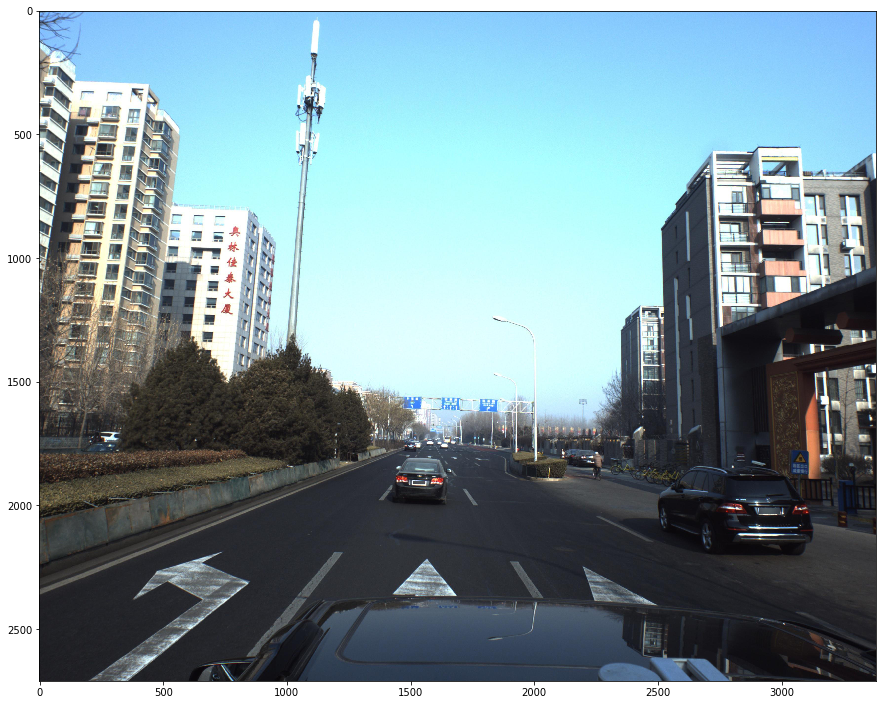

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(plt.imread('/content/sample_data/train_images/ID_00da89c68.jpg'))

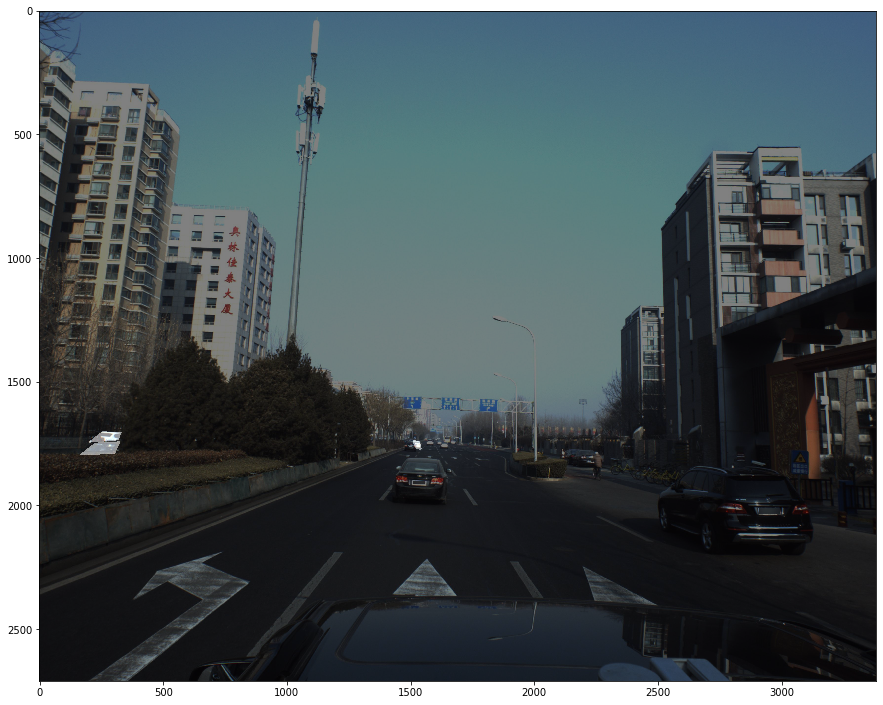

In [36]:
# mask with a transparaent overlay
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(plt.imread('/content/sample_data/train_images/ID_00da89c68.jpg'))
plt.imshow(plt.imread('/content/sample_data/train_masks/ID_00da89c68.jpg'), alpha = 0.5)
plt.show()

In [37]:
df_train_expanded[df_train_expanded['ImageId'] == 'ID_00da89c68']

ImageId  model_type       yaw  ...         x         y        z
26139  ID_00da89c68          28  0.140118  ...  -1.24689   5.16628  22.1390
26140  ID_00da89c68          71  0.164673  ...   6.45246   3.82782  13.8356
26141  ID_00da89c68          12  0.175166  ...  11.71570  10.29580  52.1423
26142  ID_00da89c68          16  0.140118  ...  -6.79029  14.85130  84.3093
26143  ID_00da89c68          16  0.175166  ...  13.99090  13.03070  67.0257

[5 rows x 8 columns]

In [0]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [0]:
# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

In [0]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image
    
def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [0]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

In [0]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

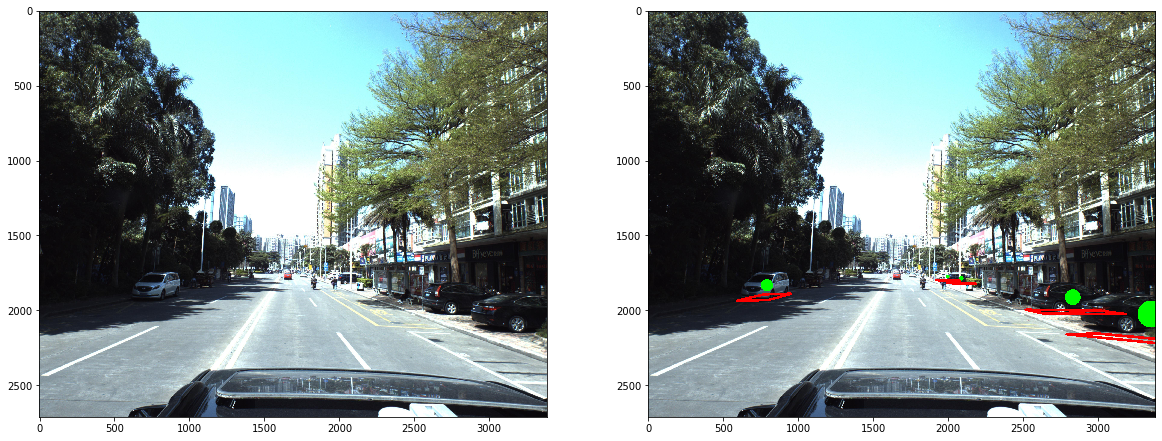

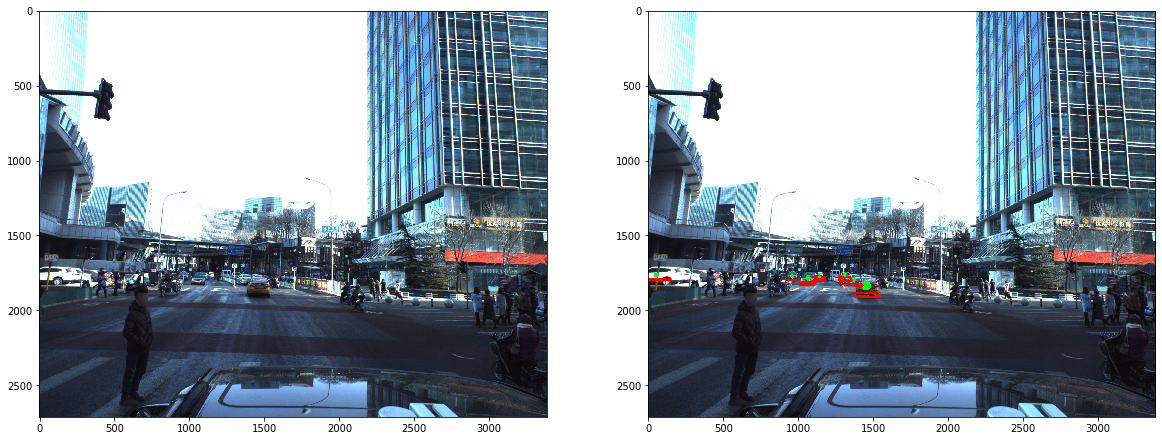

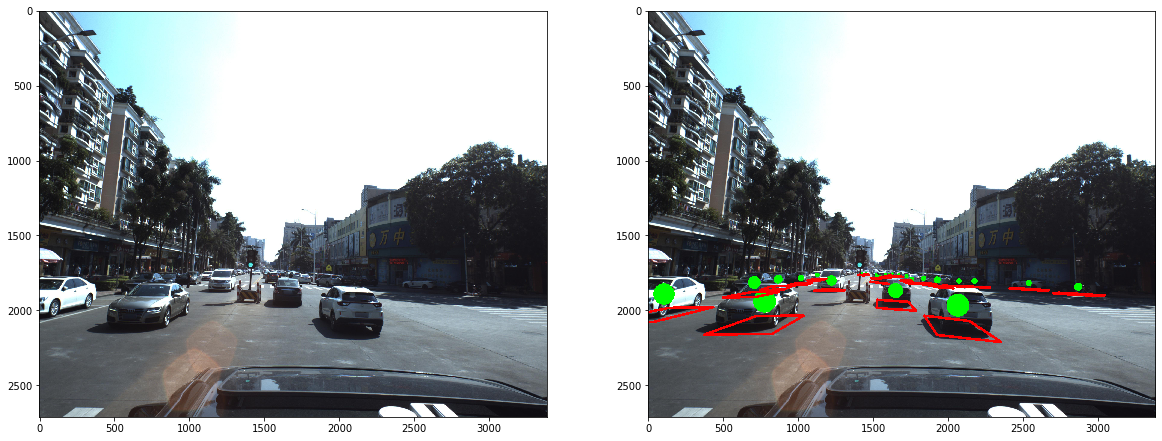

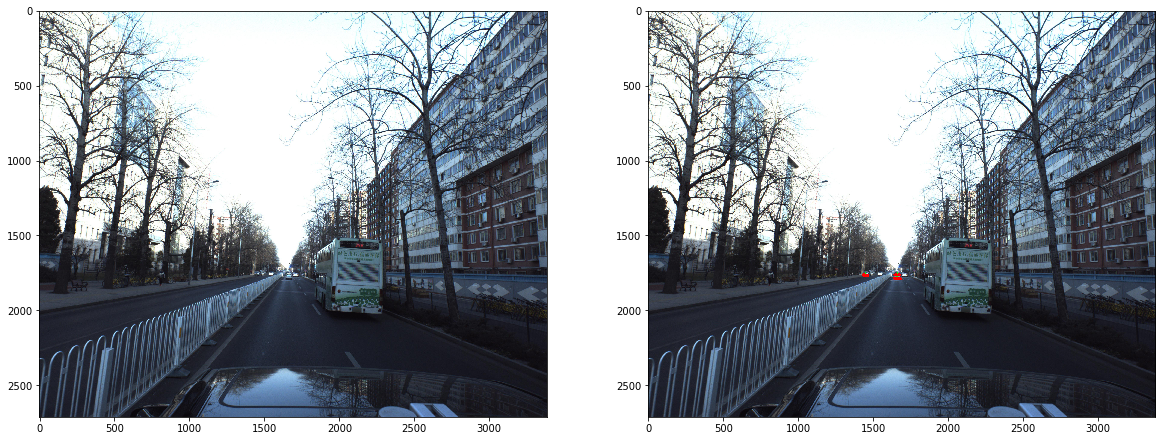

In [56]:
n_rows = 4

for idx in range(n_rows):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    img = imread( '/content/sample_data/train_images/' + df_train['ImageId'].iloc[idx] + '.jpg')
    axes[0].imshow(img)
    img_vis = visualize(img, str2coords(df_train['PredictionString'].iloc[idx]))
    axes[1].imshow(img_vis)
    plt.show()

In [0]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

In [0]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

img.shape (512, 2048, 3) std: 0.20687735
mask.shape (64, 256) std: 0.017466618
regr.shape (64, 256, 7) std: 0.007385718


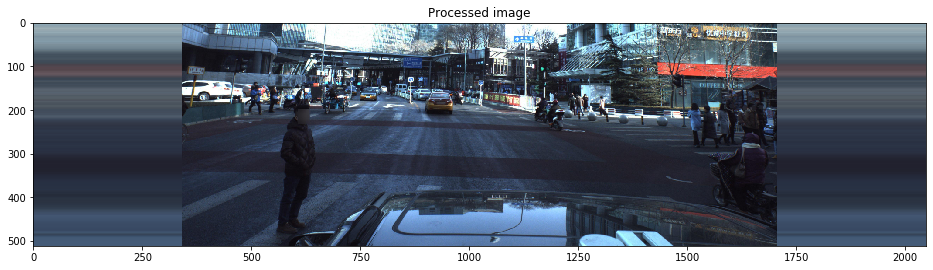

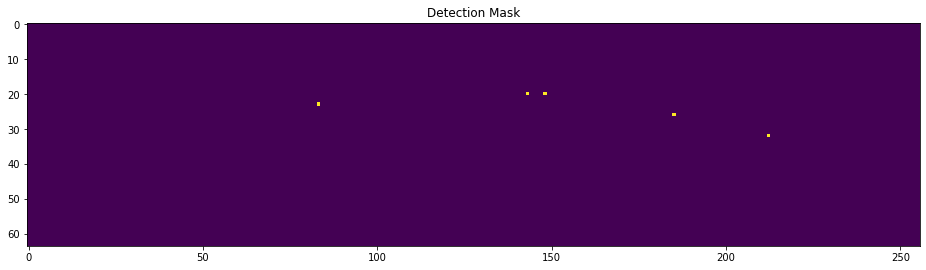

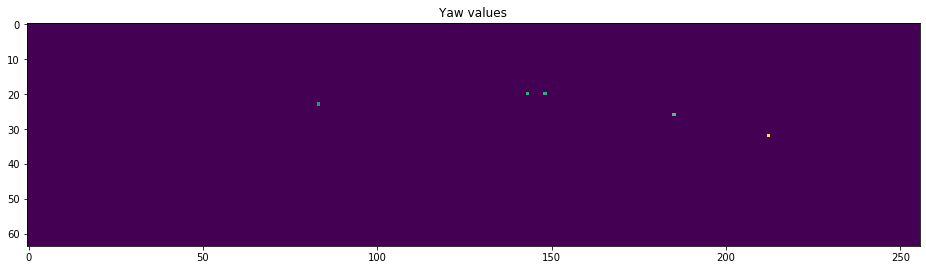

In [69]:
IMG_WIDTH = 2048
IMG_HEIGHT = IMG_WIDTH // 4
MODEL_SCALE = 8

def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

img0 = imread('/content/sample_data/train_images/' + df_train['ImageId'][1] + '.jpg')
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, df_train['PredictionString'][0])

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(16,16))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                # Zero-initialize the last BN in each residual branch,

        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)

In [0]:
class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
        self.base_model = resnet18(pretrained=False)
        
        # Lateral layers convert resnet outputs to a common feature size
        self.lat8 = nn.Conv2d(128, 256, 1)
        self.lat16 = nn.Conv2d(256, 256, 1)
        self.lat32 = nn.Conv2d(512, 256, 1)
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

       
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 , 512) #+ 1024
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        #feats = self.base_model.extract_features(x)
                # Run frontend network
        feats8, feats16, feats32 = self.base_model(x)
        lat8 = F.relu(self.bn8(self.lat8(feats8)))
        lat16 = F.relu(self.bn16(self.lat16(feats16)))
        lat32 = F.relu(self.bn32(self.lat32(feats32)))
        
        # Add positional info
        mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        feats = torch.cat([lat32, mesh2], 1)
        #print(feats.shape)
        #print (x4.shape)
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

pytorch

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [0]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

BATCH_SIZE = 2

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [88]:

#Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "Gpu")
print(device)

n_epochs = 10 #6

model = CentResnet(8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda


In [0]:
img_batch = torch.randn((1,3,512,2048))
#test = model(img_batch.to(device))

In [0]:
def criterion(prediction, mask, regr, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    # Sum
    loss = torch.log(mask_loss) + regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss

In [0]:
def train(epoch, history=None):
    model.train()
    t = tqdm(train_loader)
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(t):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch)
        t.set_description('train_loss (loss=%g)' %loss)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data))
    
def evaluate(epoch, history=None):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            loss += criterion(output, mask_batch, regr_batch, size_average=False).data
    
    loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    print('Dev loss: {:.4f}'.format(loss))

In [98]:
n_epochs

10

In [0]:
%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, history)
    evaluate(epoch, history)

In [92]:
## Just for checking the shapes to manage our Unet
i = 0
for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
    print(img_batch.shape)
    print(mask_batch.shape)
    print(regr_batch.shape)
    i+=1
    if i>1:
        break 

  0%|          | 0/2110 [00:00<?, ?it/s]

ValueError: ignored

In [23]:
df_train = pd.DataFrame({'id':train_id_arr,'image_path':train_image_arr,'mask_path':train_mask_arr})
 
df_train["image_array"] = [np.array(load_img(path=file_path, color_mode="grayscale")) / 255 for file_path in tqdm(df_train.image_path)]
df_train["mask_array"] = [np.array(load_img(path=file_path, color_mode="grayscale")) / 255 for file_path in tqdm(df_train.mask_path)]

NameError: ignored